In [4]:
!wget -O tiny-imagenet-200.zip https://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip
import os
import shutil
import random
import pandas as pd
import glob
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Confirm GPU is detected (optional)
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Found GPU at: {device_name}")
else:
    print("No GPU found. Using CPU...")

# ------------------------------------------------------
# Define paths to the cover and secret image folders
# ------------------------------------------------------
cover_train_paths = glob.glob('/content/tiny-imagenet-200/train/n01443537/images/*')
secret_train_paths = glob.glob('/content/tiny-imagenet-200/train/n01629819/images/*')

cover_images = []
secret_images = []

# ------------------------------------------------------
# Load each image as (64,64,3) and append to lists
# ------------------------------------------------------
for cover, sc1 in zip(sorted(cover_train_paths), sorted(secret_train_paths)):
    # Convert to RGB in case some images have different modes
    cov = Image.open(cover).convert("RGB").resize((64,64))
    s1 = Image.open(sc1).convert("RGB").resize((64,64))
    cover_images.append(cov)
    secret_images.append(s1)

print(f"Number of cover images: {len(cover_images)}")
print(f"Number of secret images: {len(secret_images)}")

# ------------------------------------------------------
# Normalize the images (convert [0,255] -> [0,1])
# ------------------------------------------------------
def normalize_images(images):
    return np.array([np.array(img) / 255.0 for img in images])

cover_images = normalize_images(cover_images)
secret_images = normalize_images(secret_images)

# ------------------------------------------------------
# Train/Test Split
# ------------------------------------------------------
X_cover_train, X_cover_val, X_secret_train, X_secret_val = train_test_split(
    cover_images, secret_images, test_size=0.2, random_state=42
)

# ------------------------------------------------------
# Create tf.data.Dataset objects
# ------------------------------------------------------
BATCH_SIZE = 32
BUFFER_SIZE = 100

def create_dataset(X_cover, X_secret, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(((X_cover, X_secret), (X_cover, X_secret)))
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(X_cover_train, X_secret_train, BATCH_SIZE, BUFFER_SIZE)
val_dataset = create_dataset(X_cover_val, X_secret_val, BATCH_SIZE, BUFFER_SIZE)
# ===========================
# 3A. Encoder Custom Layers
# ===========================

class _PrepNetwork1Layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(_PrepNetwork1Layer, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

        self.conv4 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), strides=1, padding='same')
        self.conv5 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), strides=1, padding='same')
        self.conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), strides=1, padding='same')

    def call(self, secret_image):
        output_1 = tf.nn.relu(self.conv1(secret_image))
        output_2 = tf.nn.relu(self.conv2(secret_image))
        output_3 = tf.nn.relu(self.conv3(secret_image))

        concatenated_image = tf.concat([output_1, output_2, output_3], axis=3)

        output_4 = tf.nn.relu(self.conv4(concatenated_image))
        output_5 = tf.nn.relu(self.conv5(concatenated_image))
        output_6 = tf.nn.relu(self.conv6(concatenated_image))

        final_concat_image = tf.concat([output_4, output_5, output_6], axis=3)
        return final_concat_image

class _HidingNetworkLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(_HidingNetworkLayer, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), padding='same')

        self.conv4 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), padding='same')
        self.conv5 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same')
        self.conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), padding='same')

        self.conv7 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), padding='same')
        self.conv8 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same')
        self.conv9 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), padding='same')

        self.conv10 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), padding='same')
        self.conv11 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same')
        self.conv12 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), padding='same')

        self.conv13 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3, 3), padding='same')
        self.conv14 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same')
        self.conv15 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), padding='same')

        self.final_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same')

    def call(self, inputs):
        secret_image_1, cover_image = inputs

        # Concatenate along the channel dimension
        concatenated_secrets = tf.concat([cover_image, secret_image_1], axis=3)

        output_1 = tf.nn.relu(self.conv1(concatenated_secrets))
        output_2 = tf.nn.relu(self.conv2(concatenated_secrets))
        output_3 = tf.nn.relu(self.conv3(concatenated_secrets))
        concat_1 = tf.concat([output_1, output_2, output_3], axis=3)

        output_4 = tf.nn.relu(self.conv4(concat_1))
        output_5 = tf.nn.relu(self.conv5(concat_1))
        output_6 = tf.nn.relu(self.conv6(concat_1))
        concat_2 = tf.concat([output_4, output_5, output_6], axis=3)

        output_7 = tf.nn.relu(self.conv7(concat_2))
        output_8 = tf.nn.relu(self.conv8(concat_2))
        output_9 = tf.nn.relu(self.conv9(concat_2))
        concat_3 = tf.concat([output_7, output_8, output_9], axis=3)

        output_10 = tf.nn.relu(self.conv10(concat_3))
        output_11 = tf.nn.relu(self.conv11(concat_3))
        output_12 = tf.nn.relu(self.conv12(concat_3))
        concat_4 = tf.concat([output_10, output_11, output_12], axis=3)

        output_13 = tf.nn.relu(self.conv13(concat_4))
        output_14 = tf.nn.relu(self.conv14(concat_4))
        output_15 = tf.nn.relu(self.conv15(concat_4))
        concat_5 = tf.concat([output_13, output_14, output_15], axis=3)

        output_converted_image = tf.nn.relu(self.final_layer(concat_5))
        return output_converted_image
def prep_network_1(secret_image):
    layer = _PrepNetwork1Layer()
    return layer(secret_image)

def hiding_network(secret_image_1, cover_image):
    layer = _HidingNetworkLayer()
    return layer([secret_image_1, cover_image])

def encoder(secret_image, cover_image):
    prepped_secret_image = prep_network_1(secret_image)
    encoded_image = hiding_network(prepped_secret_image, cover_image)
    return encoded_image

# Build the Encoder Model
secret_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name='secret_image_input')
cover_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name='cover_image_input')
encoded_image_output = encoder(secret_image_input, cover_image_input)

encoder_model = tf.keras.Model(
    inputs=[secret_image_input, cover_image_input],
    outputs=encoded_image_output,
    name='encoder_model'
)

encoder_model.summary()
class _RevealNetwork1Layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(_RevealNetwork1Layer, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding='same')
        self.conv3 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), padding='same')

        self.conv4 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), padding='same')
        self.conv5 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding='same')
        self.conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), padding='same')

        self.conv7 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), padding='same')
        self.conv8 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding='same')
        self.conv9 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), padding='same')

        self.conv10 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), padding='same')
        self.conv11 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding='same')
        self.conv12 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), padding='same')

        self.conv13 = tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), padding='same')
        self.conv14 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), padding='same')
        self.conv15 = tf.keras.layers.Conv2D(filters=5, kernel_size=(5,5), padding='same')

        self.final_layer = tf.keras.layers.Conv2D(filters=3, kernel_size=(3,3), padding='same')

    def call(self, hidden_image):
        output_1 = tf.nn.relu(self.conv1(hidden_image))
        output_2 = tf.nn.relu(self.conv2(hidden_image))
        output_3 = tf.nn.relu(self.conv3(hidden_image))
        concat_1 = tf.concat([output_1, output_2, output_3], axis=3)

        output_4 = tf.nn.relu(self.conv4(concat_1))
        output_5 = tf.nn.relu(self.conv5(concat_1))
        output_6 = tf.nn.relu(self.conv6(concat_1))
        concat_2 = tf.concat([output_4, output_5, output_6], axis=3)

        output_7 = tf.nn.relu(self.conv7(concat_2))
        output_8 = tf.nn.relu(self.conv8(concat_2))
        output_9 = tf.nn.relu(self.conv9(concat_2))
        concat_3 = tf.concat([output_7, output_8, output_9], axis=3)

        output_10 = tf.nn.relu(self.conv10(concat_3))
        output_11 = tf.nn.relu(self.conv11(concat_3))
        output_12 = tf.nn.relu(self.conv12(concat_3))
        concat_4 = tf.concat([output_10, output_11, output_12], axis=3)

        output_13 = tf.nn.relu(self.conv13(concat_4))
        output_14 = tf.nn.relu(self.conv14(concat_4))
        output_15 = tf.nn.relu(self.conv15(concat_4))
        concat_5 = tf.concat([output_13, output_14, output_15], axis=3)

        output_revealed_image = tf.nn.relu(self.final_layer(concat_5))
        return output_revealed_image
def reveal_network1(hidden_image):
    layer = _RevealNetwork1Layer()
    return layer(hidden_image)

def decoder(hidden_image):
    return reveal_network1(hidden_image)

# Build the Decoder Model
hidden_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name="hidden_image_input")
revealed_image_output = reveal_network1(hidden_image_input)

decoder_model = tf.keras.Model(
    inputs=hidden_image_input,
    outputs=revealed_image_output,
    name="decoder_model"
)

decoder_model.summary()
combined_secret_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name="combined_secret_image_input")
combined_cover_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name="combined_cover_image_input")

combined_encoded_image_output = encoder_model([combined_secret_image_input, combined_cover_image_input])
combined_revealed_image_output = decoder_model(combined_encoded_image_output)

combined_model = tf.keras.Model(
    inputs=[combined_secret_image_input, combined_cover_image_input],
    outputs=[combined_encoded_image_output, combined_revealed_image_output],
    name="combined_model"
)

combined_model.summary()

# Custom MSE-based loss
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

combined_model.compile(
    optimizer='adam',
    loss=[custom_loss, custom_loss],
    loss_weights=[0.5, 0.5]
)
EPOCHS = 80

combined_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)
%cd /content

!mkdir -p /content/tiny-imagenet-models

combined_model.save('/content/tiny-imagenet-models/combined_model.h5')
encoder_model.save('/content/tiny-imagenet-models/encoder_model.h5')
decoder_model.save('/content/tiny-imagenet-models/decoder_model.h5')

print("Models saved in /content/tiny-imagenet-models/")

# Take one batch of data from the val_dataset
(val_data, _) = next(iter(val_dataset))
cover_batch, secret_batch = val_data

# IMPORTANT: The input order to the encoder is [secret_batch, cover_batch]
hidden_batch = encoder_model.predict([cover_batch, secret_batch])

# Decoding from the hidden images
revealed_batch = decoder_model.predict(hidden_batch)

def calculate_ssim(cover_image, stego_image, max_val=1.0):
    ssim_value = tf.image.ssim(cover_image, stego_image, max_val=max_val)
    return tf.reduce_mean(ssim_value)

# LSB functions
import numpy as np

def hide_in_LSB(cover_image, secret_image, num_bits=1):
    """Hides the secret image in the least significant bits of the cover image."""
    cover_image = np.array(cover_image * 255, dtype=np.uint8)
    secret_image = np.array(secret_image * 255, dtype=np.uint8)

    # Ensure secret image is the same shape as cover image
    if secret_image.shape != cover_image.shape:
        raise ValueError("Secret and cover images must have the same shape.")

    hidden_image = cover_image.copy()

    for i in range(num_bits):
        hidden_image = np.bitwise_and(hidden_image, np.bitwise_not(1 << i))
        hidden_image = np.bitwise_or(hidden_image, np.bitwise_and(np.right_shift(secret_image, (8 - num_bits + i)), 1) << i)

    return hidden_image / 255.0

def reveal_from_LSB(hidden_image, num_bits=1):
    """Reveals the secret image from the least significant bits of the hidden image."""
    hidden_image = np.array(hidden_image * 255, dtype=np.uint8)
    revealed_image = np.zeros_like(hidden_image, dtype=np.uint8)

    for i in range(num_bits):
        revealed_image = revealed_image | ((hidden_image & (1 << i)) << (8 - num_bits - i))

    return revealed_image / 255.0

print("\n==================== LSB SSIM Calculations ====================\n")

NUM_EXAMPLES = min(5, cover_batch.shape[0])

for i in range(NUM_EXAMPLES):
    original_cover = cover_batch[i]
    secret_img = secret_batch[i]
    hidden_lsb = hide_in_LSB(original_cover, secret_img, num_bits=1)
    revealed_lsb = reveal_from_LSB(hidden_lsb, num_bits=1)

    cover_exp = tf.expand_dims(original_cover, axis=0)
    secret_exp = tf.expand_dims(secret_img, axis=0)
    hidden_lsb_exp = tf.expand_dims(hidden_lsb, axis=0)
    revealed_lsb_exp = tf.expand_dims(revealed_lsb, axis=0)

    ssim_cover_lsb = calculate_ssim(cover_exp, hidden_lsb_exp)
    ssim_secret_lsb = calculate_ssim(secret_exp, revealed_lsb_exp)

    print(f"Sample {i+1}:")
    print(f"  LSB    -> SSIM(Cover vs. Stego) = {ssim_cover_lsb.numpy():.4f}")
    print(f"  LSB    -> SSIM(Secret vs. Revealed) = {ssim_secret_lsb.numpy():.4f}")
    print("--------------------------------------------------------------")

print("\n==================== CNN SSIM Calculations ====================\n")

for i in range(NUM_EXAMPLES):
    original_cover = cover_batch[i]
    secret_img = secret_batch[i]
    hidden_cnn = hidden_batch[i]
    revealed_cnn = revealed_batch[i]

    cover_exp = tf.expand_dims(original_cover, axis=0)
    secret_exp = tf.expand_dims(secret_img, axis=0)
    hidden_cnn_exp = tf.expand_dims(hidden_cnn, axis=0)
    revealed_cnn_exp = tf.expand_dims(revealed_cnn, axis=0)

    # Ensure tensors are float32
    cover_exp = tf.cast(cover_exp, tf.float32)
    hidden_cnn_exp = tf.cast(hidden_cnn_exp, tf.float32)
    secret_exp = tf.cast(secret_exp, tf.float32)
    revealed_cnn_exp = tf.cast(revealed_cnn_exp, tf.float32)

    ssim_cover_cnn = calculate_ssim(cover_exp, hidden_cnn_exp)
    ssim_secret_cnn = calculate_ssim(secret_exp, revealed_cnn_exp)

    print(f"Sample {i+1}:")
    print(f"  CNN    -> SSIM(Cover vs. Stego) = {ssim_cover_cnn.numpy():.4f}")
    print(f"  CNN    -> SSIM(Secret vs. Revealed) = {ssim_secret_cnn.numpy():.4f}")
    print("--------------------------------------------------------------")

--2025-03-30 16:31:48--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  29.3MB/s    in 6.7s    

2025-03-30 16:31:55 (35.3 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Found GPU at: /device:GPU:0
Number of cover images: 500
Number of secret images: 500


Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ secret_image_input        │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ __prep_network1_layer_3   │ (None, 64, 64, 65)     │         45,350 │ secret_image_input[0]… │
│ (_PrepNetwork1Layer)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cover_image_input         │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ __hiding_network_layer_3  │ (None, 64, 64, 3)      │        220,203 │ __prep_network1_layer… │
│ (_HidingNetworkLayer)     │                        │                │ cover_image_input[0][… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 265,553 (1.01 MB)

 Trainable params: 265,553 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ hidden_image_input (InputLayer)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ __reveal_network1_layer_3            │ (None, 64, 64, 3)           │         176,978 │
│ (_RevealNetwork1Layer)               │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,978 (691.32 KB)

 Trainable params: 176,978 (691.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "combined_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ combined_secret_image_in… │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ combined_cover_image_inp… │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_model             │ (None, 64, 64, 3)      │        265,553 │ combined_secret_image… │
│ (Functional)              │                        │                │ combined_cover_image_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_model             │ (None, 64, 64, 3)      │        176,978 │ encoder_model[0][0]    │
│ (Functional)              │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 442,531 (1.69 MB)

 Trainable params: 442,531 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - decoder_model_loss: 0.2353 - encoder_model_loss: 0.1493 - loss: 0.1928 - val_decoder_model_loss: 0.0572 - val_encoder_model_loss: 0.0523 - val_loss: 0.0545
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - decoder_model_loss: 0.0554 - encoder_model_loss: 0.0476 - loss: 0.0516 - val_decoder_model_loss: 0.0433 - val_encoder_model_loss: 0.0388 - val_loss: 0.0410
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - decoder_model_loss: 0.0443 - encoder_model_loss: 0.0331 - loss: 0.0387 - val_decoder_model_loss: 0.0377 - val_encoder_model_loss: 0.0292 - val_loss: 0.0318
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - decoder_model_loss: 0.0365 - encoder_model_loss: 0.0251 - loss: 0.0308 - val_decoder_model_loss: 0.0348 - val_encoder_model_loss: 0.0231 - val_loss: 0.0301
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - decoder_model_loss: 0.0323 - encoder_model_loss: 0.0223 - loss: 0.0273 - val_decoder_model_loss: 0.0300 

Models saved in /content/tiny-imagenet-models/
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step

==================== LSB SSIM Calculations ====================

Sample 1:
  LSB    -> SSIM(Cover vs. Stego) = 0.9979
  LSB    -> SSIM(Secret vs. Revealed) = 0.4522
--------------------------------------------------------------
Sample 2:
  LSB    -> SSIM(Cover vs. Stego) = 0.9993
  LSB    -> SSIM(Secret vs. Revealed) = 0.3814
--------------------------------------------------------------
Sample 3:
  LSB    -> SSIM(Cover vs. Stego) = 0.9994
  LSB    -> SSIM(Secret vs. Revealed) = 0.3560
--------------------------------------------------------------
Sample 4:
  LSB    -> SSIM(Cover vs. Stego) = 0.9988
  LSB    -> SSIM(Secret vs. Revealed) = 0.3064
--------------------------------------------------------------
Sample 5:
  LSB    -> SSIM(Cover vs. Stego) = 0.9973
  LSB    -> SSIM(Secret vs. Revealed) = 0.3984
---------------------------------------------------------

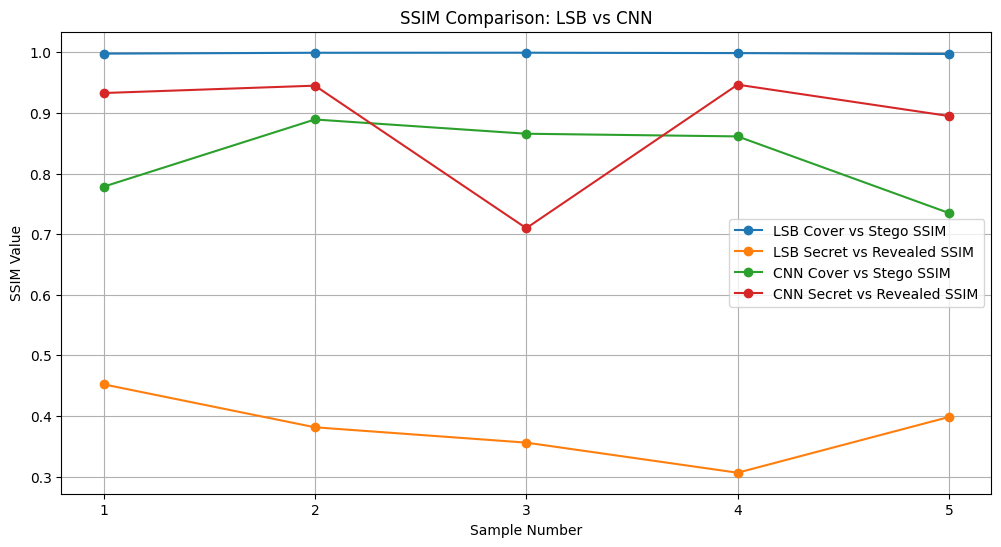

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

def calculate_ssim(cover_image, stego_image, max_val=1.0):
    ssim_value = tf.image.ssim(cover_image, stego_image, max_val=max_val)
    return tf.reduce_mean(ssim_value)

NUM_EXAMPLES = min(5, cover_batch.shape[0])

lsb_cover_ssims = []
lsb_secret_ssims = []
cnn_cover_ssims = []
cnn_secret_ssims = []

for i in range(NUM_EXAMPLES):
    original_cover = cover_batch[i]
    secret_img = secret_batch[i]

    # LSB calculations
    hidden_lsb = hide_in_LSB(original_cover, secret_img, num_bits=1)
    revealed_lsb = reveal_from_LSB(hidden_lsb, num_bits=1)
    cover_exp_lsb = tf.expand_dims(original_cover, axis=0)
    secret_exp_lsb = tf.expand_dims(secret_img, axis=0)
    hidden_lsb_exp = tf.expand_dims(hidden_lsb, axis=0)
    revealed_lsb_exp = tf.expand_dims(revealed_lsb, axis=0)

    # Ensure LSB tensors are float32
    cover_exp_lsb = tf.cast(cover_exp_lsb, tf.float32)
    hidden_lsb_exp = tf.cast(hidden_lsb_exp, tf.float32)
    secret_exp_lsb = tf.cast(secret_exp_lsb, tf.float32)
    revealed_lsb_exp = tf.cast(revealed_lsb_exp, tf.float32)

    ssim_cover_lsb = calculate_ssim(cover_exp_lsb, hidden_lsb_exp).numpy()
    ssim_secret_lsb = calculate_ssim(secret_exp_lsb, revealed_lsb_exp).numpy()
    lsb_cover_ssims.append(ssim_cover_lsb)
    lsb_secret_ssims.append(ssim_secret_lsb)

    # CNN calculations
    hidden_cnn = hidden_batch[i]
    revealed_cnn = revealed_batch[i]
    cover_exp_cnn = tf.expand_dims(original_cover, axis=0)
    secret_exp_cnn = tf.expand_dims(secret_img, axis=0)
    hidden_cnn_exp = tf.expand_dims(hidden_cnn, axis=0)
    revealed_cnn_exp = tf.expand_dims(revealed_cnn, axis=0)

    # Ensure CNN tensors are float32
    cover_exp_cnn = tf.cast(cover_exp_cnn, tf.float32)
    hidden_cnn_exp = tf.cast(hidden_cnn_exp, tf.float32)
    secret_exp_cnn = tf.cast(secret_exp_cnn, tf.float32)
    revealed_cnn_exp = tf.cast(revealed_cnn_exp, tf.float32)

    ssim_cover_cnn = calculate_ssim(cover_exp_cnn, hidden_cnn_exp).numpy()
    ssim_secret_cnn = calculate_ssim(secret_exp_cnn, revealed_cnn_exp).numpy()
    cnn_cover_ssims.append(ssim_cover_cnn)
    cnn_secret_ssims.append(ssim_secret_cnn)

# Create the graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, NUM_EXAMPLES + 1), lsb_cover_ssims, marker='o', label='LSB Cover vs Stego SSIM')
plt.plot(range(1, NUM_EXAMPLES + 1), lsb_secret_ssims, marker='o', label='LSB Secret vs Revealed SSIM')
plt.plot(range(1, NUM_EXAMPLES + 1), cnn_cover_ssims, marker='o', label='CNN Cover vs Stego SSIM')
plt.plot(range(1, NUM_EXAMPLES + 1), cnn_secret_ssims, marker='o', label='CNN Secret vs Revealed SSIM')
plt.title('SSIM Comparison: LSB vs CNN')
plt.xlabel('Sample Number')
plt.ylabel('SSIM Value')
plt.xticks(range(1, NUM_EXAMPLES + 1))
plt.legend()
plt.grid(True)
plt.show()

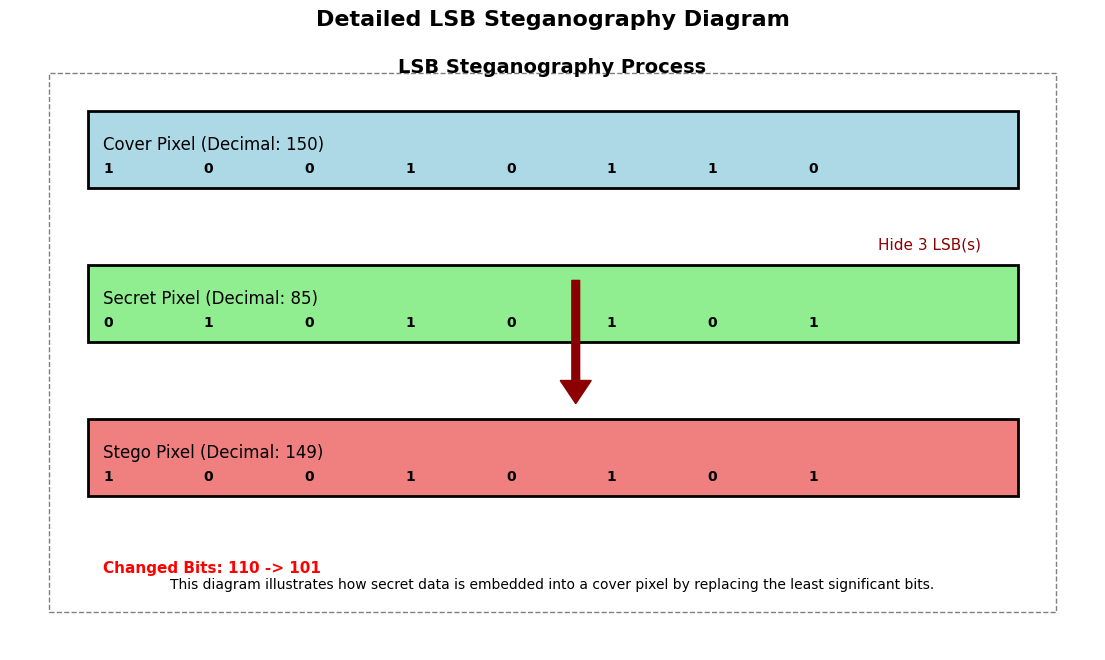

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def create_detailed_lsb_diagram(cover_pixel, secret_pixel, num_bits=1):
    """Creates a detailed and catchy diagram for LSB steganography."""

    cover_binary = bin(cover_pixel)[2:].zfill(8)
    secret_binary = bin(secret_pixel)[2:].zfill(8)

    hidden_binary = list(cover_binary)
    for i in range(num_bits):
        hidden_binary[8 - num_bits + i] = secret_binary[8 - num_bits + i]
    hidden_binary = "".join(hidden_binary)
    hidden_pixel = int(hidden_binary, 2)

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 8)
    ax.axis('off')

    # Cover Pixel Representation (Detailed)
    ax.add_patch(patches.Rectangle((1, 6), 12, 1, facecolor='lightblue', edgecolor='black', linewidth=2))
    ax.text(1.2, 6.5, f"Cover Pixel (Decimal: {cover_pixel})", fontsize=12)
    for i, bit in enumerate(cover_binary):
        ax.text(1.2 + i * 1.3, 6.2, bit, fontsize=10, fontweight='bold')

    # Secret Pixel Representation (Detailed)
    ax.add_patch(patches.Rectangle((1, 4), 12, 1, facecolor='lightgreen', edgecolor='black', linewidth=2))
    ax.text(1.2, 4.5, f"Secret Pixel (Decimal: {secret_pixel})", fontsize=12)
    for i, bit in enumerate(secret_binary):
        ax.text(1.2 + i * 1.3, 4.2, bit, fontsize=10, fontweight='bold')

    # LSB Hiding Arrow (Enhanced) - Corrected Coordinates
    arrow = patches.FancyArrow(
        x=7.3,  # Adjust x to align with the last few bits
        y=4.8, # Adjust y to start near the cover pixel bits
        dx=0,
        dy=-1.3, # Adjust dy to point towards the secret pixel bits
        width=0.1,
        head_width=0.4,
        head_length=0.3,
        fc='darkred',
        ec='darkred'
    )
    ax.add_patch(arrow)
    ax.text(11.2, 5.2, f"Hide {num_bits} LSB(s)", fontsize=11, color='darkred')

    # Hidden Pixel Representation (Detailed)
    ax.add_patch(patches.Rectangle((1, 2), 12, 1, facecolor='lightcoral', edgecolor='black', linewidth=2))
    ax.text(1.2, 2.5, f"Stego Pixel (Decimal: {hidden_pixel})", fontsize=12)
    for i, bit in enumerate(hidden_binary):
        ax.text(1.2 + i * 1.3, 2.2, bit, fontsize=10, fontweight='bold')

    # Highlight Changed Bits (Enhanced)
    changed_bits_text = f"Changed Bits: {cover_binary[8 - num_bits:]} -> {hidden_binary[8 - num_bits:]}"
    ax.text(1.2, 1, changed_bits_text, fontsize=11, color='red', fontweight='bold')

    # Information Box
    ax.add_patch(patches.Rectangle((0.5, 0.5), 13, 7, facecolor='none', edgecolor='gray', linestyle='--', linewidth=1))
    ax.text(7, 7.5, "LSB Steganography Process", fontsize=14, ha='center', fontweight='bold')
    ax.text(7, 0.8, "This diagram illustrates how secret data is embedded into a cover pixel by replacing the least significant bits.", fontsize=10, ha='center')

    plt.title("Detailed LSB Steganography Diagram", fontsize=16, fontweight='bold')
    plt.show()

# Example Usage
cover_pixel = 150
secret_pixel = 85
num_bits = 3
create_detailed_lsb_diagram(cover_pixel, secret_pixel, num_bits)

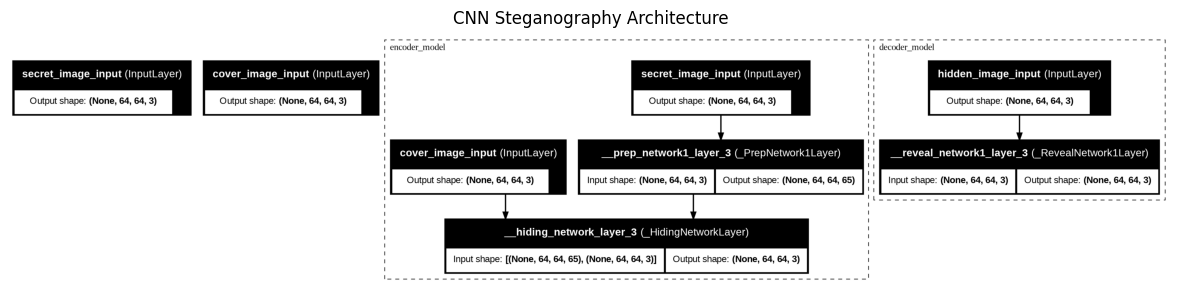

In [35]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image

# Assuming you have already defined your encoder_model and decoder_model

def create_cnn_steganography_diagram(encoder_model, decoder_model, filename="cnn_steganography_diagram.png"):
    """
    Creates a diagram representing the CNN steganography architecture.

    Args:
        encoder_model: The Keras encoder model.
        decoder_model: The Keras decoder model.
        filename: The filename to save the diagram.
    """

    # Create a combined model for visualization
    secret_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name='secret_image_input')
    cover_image_input = tf.keras.layers.Input(shape=(64, 64, 3), name='cover_image_input')
    encoded_image_output = encoder_model([secret_image_input, cover_image_input])
    decoded_image_output = decoder_model(encoded_image_output)

    combined_model = tf.keras.Model(inputs=[secret_image_input, cover_image_input], outputs=[encoded_image_output, decoded_image_output])

    # Generate the diagram
    plot_model(combined_model, to_file=filename, show_shapes=True, show_layer_names=True, expand_nested=True)

    # Display the diagram
    img = mpimg.imread(filename)
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.title("CNN Steganography Architecture")
    plt.show()

# Example usage (assuming encoder_model and decoder_model are already defined)
create_cnn_steganography_diagram(encoder_model, decoder_model)

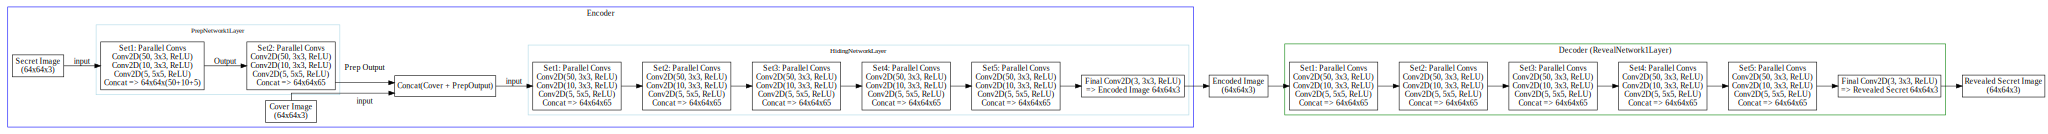

In [40]:
# -----------------------------------------------
# 1) Install and Import
# -----------------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

import graphviz
from graphviz import Digraph

# -----------------------------------------------
# 2) Create the base Digraph
# -----------------------------------------------
dot = Digraph('CNN_Steganography', format='png')

# rankdir='LR' arranges the graph from left to right
dot.attr(rankdir='LR', splines='ortho')

# -----------------------------------------------
# 3) Define Input Nodes
# -----------------------------------------------
dot.node('SecretImage', 'Secret Image\n(64x64x3)', shape='box')
dot.node('CoverImage',  'Cover Image\n(64x64x3)', shape='box')

# ===============================================
# 4) Encoder (PrepNetwork1 + HidingNetwork)
# ===============================================
with dot.subgraph(name='cluster_encoder') as enc:
    enc.attr(label='Encoder', fontsize='14', color='blue')

    # --------------------
    # 4A) PrepNetwork1
    # --------------------
    with enc.subgraph(name='cluster_prep') as prep:
        prep.attr(label='PrepNetwork1Layer', fontsize='12', color='lightblue')

        # First set of parallel convs -> concat
        prep.node(
            'PrepSet1',
            '''Set1: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x(50+10+5)''',
            shape='box'
        )

        # Second set of parallel convs -> concat
        prep.node(
            'PrepSet2',
            '''Set2: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
            shape='box'
        )

        prep.edge('PrepSet1', 'PrepSet2', label='Output')

    # --------------------
    # 4B) HidingNetwork
    # --------------------
    with enc.subgraph(name='cluster_hiding') as hid:
        hid.attr(label='HidingNetworkLayer', fontsize='12', color='lightblue')

        # 5 sets of parallel convs -> concat
        hid.node(
            'HidingSet1',
            '''Set1: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
            shape='box'
        )

        hid.node(
            'HidingSet2',
            '''Set2: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
            shape='box'
        )

        hid.node(
            'HidingSet3',
            '''Set3: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
            shape='box'
        )

        hid.node(
            'HidingSet4',
            '''Set4: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
            shape='box'
        )

        hid.node(
            'HidingSet5',
            '''Set5: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
            shape='box'
        )

        hid.node(
            'HidingFinal',
            '''Final Conv2D(3, 3x3, ReLU)
=> Encoded Image 64x64x3''',
            shape='box'
        )

        # Chain them
        hid.edge('HidingSet1', 'HidingSet2')
        hid.edge('HidingSet2', 'HidingSet3')
        hid.edge('HidingSet3', 'HidingSet4')
        hid.edge('HidingSet4', 'HidingSet5')
        hid.edge('HidingSet5', 'HidingFinal')

    # --------------------------------
    # 4C) Connect Prep to Hiding
    # --------------------------------
    enc.node('ConcatCover', 'Concat(Cover + PrepOutput)', shape='box')

    # Connections inside Encoder
    enc.edge('SecretImage', 'PrepSet1', label='input')
    enc.edge('PrepSet2', 'ConcatCover', label='Prep Output')
    enc.edge('CoverImage', 'ConcatCover', label='input')
    enc.edge('ConcatCover', 'HidingSet1', label='input')

# Encoded Image node
dot.node('EncodedImage', 'Encoded Image\n(64x64x3)', shape='box')
dot.edge('HidingFinal', 'EncodedImage')

# ===============================================
# 5) Decoder (RevealNetwork1)
# ===============================================
with dot.subgraph(name='cluster_decoder') as dec:
    dec.attr(label='Decoder (RevealNetwork1Layer)', fontsize='14', color='green')

    # 5 sets of parallel convs -> concat
    dec.node(
        'RevealSet1',
        '''Set1: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
        shape='box'
    )

    dec.node(
        'RevealSet2',
        '''Set2: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
        shape='box'
    )

    dec.node(
        'RevealSet3',
        '''Set3: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
        shape='box'
    )

    dec.node(
        'RevealSet4',
        '''Set4: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
        shape='box'
    )

    dec.node(
        'RevealSet5',
        '''Set5: Parallel Convs
Conv2D(50, 3x3, ReLU)
Conv2D(10, 3x3, ReLU)
Conv2D(5, 5x5, ReLU)
Concat => 64x64x65''',
        shape='box'
    )

    dec.node(
        'RevealFinal',
        '''Final Conv2D(3, 3x3, ReLU)
=> Revealed Secret 64x64x3''',
        shape='box'
    )

    # Chain them
    dec.edge('RevealSet1', 'RevealSet2')
    dec.edge('RevealSet2', 'RevealSet3')
    dec.edge('RevealSet3', 'RevealSet4')
    dec.edge('RevealSet4', 'RevealSet5')
    dec.edge('RevealSet5', 'RevealFinal')

# Encoded Image -> first decoder block
dot.edge('EncodedImage', 'RevealSet1')

# Output node for revealed secret
dot.node('RevealedSecretImage', 'Revealed Secret Image\n(64x64x3)', shape='box')
dot.edge('RevealFinal', 'RevealedSecretImage')

# -----------------------------------------------
# 6) Render and Display
# -----------------------------------------------
dot.render('CNN_Steganography_Diagram', view=False)
dot


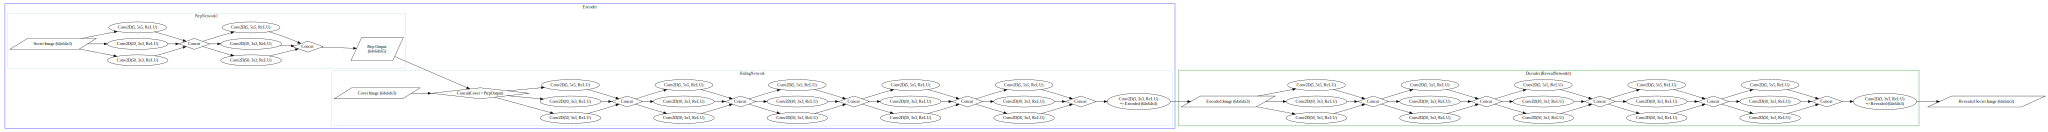

In [41]:
# --------------------------------------------------
# 1) Install and import Graphviz
# --------------------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

# --------------------------------------------------
# 2) Create base Digraph
# --------------------------------------------------
dot = Digraph("CNN_Steganography_Detailed", format="png")

# Arrange nodes from left to right
dot.attr(rankdir="LR")

# Shapes we'll use:
# - Inputs/outputs: parallelogram
# - Convolution layers: ellipse
# - Concat operations: diamond

# --------------------------------------------------
# 3) Define input nodes
# --------------------------------------------------
dot.node("SecretImage", "Secret Image (64x64x3)", shape="parallelogram")
dot.node("CoverImage",  "Cover Image (64x64x3)", shape="parallelogram")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# HELPER: Draw 3 parallel conv layers + concat
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def create_parallel_conv_set(graph, prefix, input_node,
                             conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")],
                             next_node=None):
    """
    Creates 3 conv nodes + 1 concat node in a subgraph,
    hooking them up to 'input_node' and optionally connecting concat -> next_node.

    Args:
      graph      : the Digraph (subgraph or main).
      prefix     : unique name prefix, e.g. "prep_set1"
      input_node : the node name feeding into these conv layers.
      conv_specs : list of (filters, kernel) for each parallel conv.
      next_node  : if not None, connect the concat node to next_node.
    Returns:
      concat_name: the name of the concat node (so the caller can connect it forward).
    """
    # Create the 3 conv nodes
    conv_nodes = []
    for i, (filters, ksz) in enumerate(conv_specs, start=1):
        conv_name = f"{prefix}_conv{i}"
        conv_label = f"Conv2D({filters}, {ksz}, ReLU)"
        graph.node(conv_name, conv_label, shape="ellipse")
        # Edge from input to this conv node
        graph.edge(input_node, conv_name)
        conv_nodes.append(conv_name)

    # Create the concat node
    concat_name = f"{prefix}_concat"
    graph.node(concat_name, "Concat", shape="diamond")
    # Hook each conv -> concat
    for c in conv_nodes:
        graph.edge(c, concat_name)

    # If there's a next node, connect concat -> next_node
    if next_node is not None:
        graph.edge(concat_name, next_node)

    return concat_name

# --------------------------------------------------
# 4) Encoder: cluster with PrepNetwork1 + HidingNetwork
# --------------------------------------------------
with dot.subgraph(name="cluster_encoder") as enc:
    enc.attr(label="Encoder", color="blue", fontsize="14")

    # ~~~~~~~~~~~~~~~
    # 4A) PrepNetwork1
    # ~~~~~~~~~~~~~~~
    with enc.subgraph(name="cluster_prep") as prep:
        prep.attr(label="PrepNetwork1", color="lightblue", fontsize="12")

        # Set1
        prep_set1_concat = create_parallel_conv_set(
            prep,
            prefix="prep_set1",
            input_node="SecretImage",
            conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
        )
        # Set2
        prep_set2_concat = create_parallel_conv_set(
            prep,
            prefix="prep_set2",
            input_node=prep_set1_concat,
            conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
        )

        # We'll treat the output of prep_set2 as "PrepOutput"
        prep.node("PrepOutput", "Prep Output\n(64x64x65)", shape="parallelogram")
        prep.edge(prep_set2_concat, "PrepOutput")

    # ~~~~~~~~~~~~~~~
    # 4B) HidingNetwork
    # ~~~~~~~~~~~~~~~
    with enc.subgraph(name="cluster_hiding") as hid:
        hid.attr(label="HidingNetwork", color="lightblue", fontsize="12")

        # We have to concat the cover image + prep output before Set1
        hid.node("Cover_Secret_Concat", "Concat(Cover + PrepOutput)", shape="diamond")
        # Hook cover & prep output into that
        hid.edge("CoverImage", "Cover_Secret_Concat")
        hid.edge("PrepOutput", "Cover_Secret_Concat")

        # Now run the 5 sets of parallel conv
        hiding_set1_concat = create_parallel_conv_set(
            hid,
            prefix="hiding_set1",
            input_node="Cover_Secret_Concat",
            conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
        )
        hiding_set2_concat = create_parallel_conv_set(
            hid,
            prefix="hiding_set2",
            input_node=hiding_set1_concat,
            conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
        )
        hiding_set3_concat = create_parallel_conv_set(
            hid,
            prefix="hiding_set3",
            input_node=hiding_set2_concat,
            conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
        )
        hiding_set4_concat = create_parallel_conv_set(
            hid,
            prefix="hiding_set4",
            input_node=hiding_set3_concat,
            conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
        )
        hiding_set5_concat = create_parallel_conv_set(
            hid,
            prefix="hiding_set5",
            input_node=hiding_set4_concat,
            conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
        )

        # Final conv layer -> EncodedImage
        hid.node("HidingFinal", "Conv2D(3, 3x3, ReLU)\n=> Encoded (64x64x3)", shape="ellipse")
        hid.edge(hiding_set5_concat, "HidingFinal")

# We'll define the encoded image as a parallelogram node
dot.node("EncodedImage", "Encoded Image (64x64x3)", shape="parallelogram")
dot.edge("HidingFinal", "EncodedImage")

# --------------------------------------------------
# 5) Decoder: RevealNetwork1
# --------------------------------------------------
with dot.subgraph(name="cluster_decoder") as dec:
    dec.attr(label="Decoder (RevealNetwork1)", color="green", fontsize="14")

    # We'll feed "EncodedImage" into set1 of reveal
    # 5 sets of parallel conv + final conv => RevealedImage

    reveal_set1_concat = create_parallel_conv_set(
        dec,
        prefix="reveal_set1",
        input_node="EncodedImage",
        conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
    )
    reveal_set2_concat = create_parallel_conv_set(
        dec,
        prefix="reveal_set2",
        input_node=reveal_set1_concat,
        conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
    )
    reveal_set3_concat = create_parallel_conv_set(
        dec,
        prefix="reveal_set3",
        input_node=reveal_set2_concat,
        conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
    )
    reveal_set4_concat = create_parallel_conv_set(
        dec,
        prefix="reveal_set4",
        input_node=reveal_set3_concat,
        conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
    )
    reveal_set5_concat = create_parallel_conv_set(
        dec,
        prefix="reveal_set5",
        input_node=reveal_set4_concat,
        conv_specs=[(50,"3x3"),(10,"3x3"),(5,"5x5")]
    )

    # Final reveal conv
    dec.node("RevealFinal", "Conv2D(3, 3x3, ReLU)\n=> Revealed (64x64x3)", shape="ellipse")
    dec.edge(reveal_set5_concat, "RevealFinal")

# Output node
dot.node("RevealedSecretImage", "Revealed Secret Image (64x64x3)", shape="parallelogram")
dot.edge("RevealFinal", "RevealedSecretImage")

# --------------------------------------------------
# 6) Render and display
# --------------------------------------------------
dot.render("CNN_Steganography_Detailed", view=False)
dot


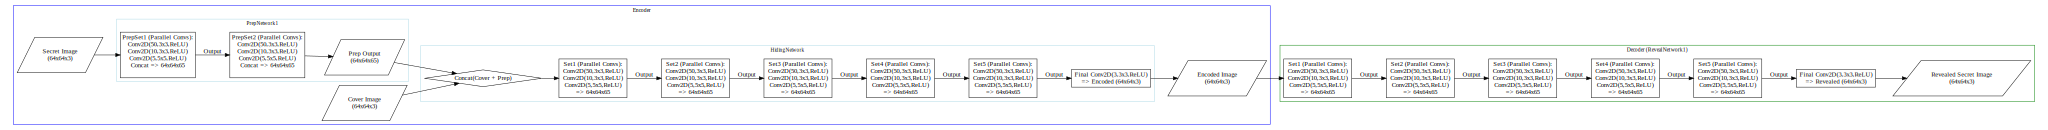

In [42]:
# --------------------------------------------------
# 1) Install and import Graphviz
# --------------------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

# --------------------------------------------------
# 2) Create the base Digraph (horizontal layout)
# --------------------------------------------------
dot = Digraph('CNN_Steganography_Simplified', format='png')
dot.attr(rankdir='LR')  # Left-to-right arrangement

# --------------------------------------------------
# 3) Define Inputs and Outputs
# --------------------------------------------------
dot.node('SecretImage', label='Secret Image\n(64x64x3)', shape='parallelogram')
dot.node('CoverImage',  label='Cover Image\n(64x64x3)', shape='parallelogram')
dot.node('EncodedImage', label='Encoded Image\n(64x64x3)', shape='parallelogram')
dot.node('RevealedSecretImage', label='Revealed Secret Image\n(64x64x3)', shape='parallelogram')

# ============================================
# 4) Encoder Subgraph
# ============================================
with dot.subgraph(name='cluster_encoder') as enc:
    enc.attr(label='Encoder', color='blue', fontsize='12')

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 4A) PrepNetwork1
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    with enc.subgraph(name='cluster_prep') as prep:
        prep.attr(label='PrepNetwork1', color='lightblue', fontsize='11')

        # Prep Set1
        prep.node('PrepSet1',
        '''PrepSet1 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
Concat => 64x64x65
        ''', shape='box')

        # Prep Set2
        prep.node('PrepSet2',
        '''PrepSet2 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
Concat => 64x64x65
        ''', shape='box')

        # Connect them
        prep.edge('PrepSet1', 'PrepSet2', label='Output')

        # We'll have a node for "PrepOutput" as if it's the final output
        prep.node('PrepOutput', 'Prep Output\n(64x64x65)', shape='parallelogram')
        prep.edge('PrepSet2', 'PrepOutput')

        # Connect the secret image into the first prep set
        enc.edge('SecretImage', 'PrepSet1')

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # 4B) HidingNetwork
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    with enc.subgraph(name='cluster_hiding') as hid:
        hid.attr(label='HidingNetwork', color='lightblue', fontsize='11')

        # A diamond for concatenating CoverImage + PrepOutput
        hid.node('CoverSecretConcat', 'Concat(Cover + Prep)', shape='diamond')

        # 5 sets
        hid.node('HidingSet1',
        '''Set1 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

        hid.node('HidingSet2',
        '''Set2 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

        hid.node('HidingSet3',
        '''Set3 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

        hid.node('HidingSet4',
        '''Set4 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

        hid.node('HidingSet5',
        '''Set5 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

        # Final conv => Encoded image
        hid.node('HidingFinal',
        'Final Conv2D(3,3x3,ReLU)\n=> Encoded (64x64x3)', shape='box')

        # Connect the diamond to the sets
        hid.edge('CoverSecretConcat', 'HidingSet1')
        hid.edge('HidingSet1', 'HidingSet2', label='Output')
        hid.edge('HidingSet2', 'HidingSet3', label='Output')
        hid.edge('HidingSet3', 'HidingSet4', label='Output')
        hid.edge('HidingSet4', 'HidingSet5', label='Output')
        hid.edge('HidingSet5', 'HidingFinal', label='Output')

        # Connect the final to EncodedImage
        enc.edge('HidingFinal', 'EncodedImage')

    # Connect (Cover, PrepOutput) -> diamond
    enc.edge('CoverImage', 'CoverSecretConcat')
    enc.edge('PrepOutput', 'CoverSecretConcat')


# ============================================
# 5) Decoder Subgraph (RevealNetwork1)
# ============================================
with dot.subgraph(name='cluster_decoder') as dec:
    dec.attr(label='Decoder (RevealNetwork1)', color='green', fontsize='12')

    # 5 sets
    dec.node('RevealSet1',
    '''Set1 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

    dec.node('RevealSet2',
    '''Set2 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

    dec.node('RevealSet3',
    '''Set3 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

    dec.node('RevealSet4',
    '''Set4 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

    dec.node('RevealSet5',
    '''Set5 (Parallel Convs):
Conv2D(50,3x3,ReLU)
Conv2D(10,3x3,ReLU)
Conv2D(5,5x5,ReLU)
=> 64x64x65''', shape='box')

    # Final => Revealed secret
    dec.node('RevealFinal',
    '''Final Conv2D(3,3x3,ReLU)
=> Revealed (64x64x3)''', shape='box')

    # Connect them in series
    dec.edge('RevealSet1', 'RevealSet2', label='Output')
    dec.edge('RevealSet2', 'RevealSet3', label='Output')
    dec.edge('RevealSet3', 'RevealSet4', label='Output')
    dec.edge('RevealSet4', 'RevealSet5', label='Output')
    dec.edge('RevealSet5', 'RevealFinal', label='Output')

    # Connect final to the revealed secret
    dec.edge('RevealFinal', 'RevealedSecretImage')

# ------------------------------------------------
# 6) Connect EncodedImage => RevealSet1
# ------------------------------------------------
dot.edge('EncodedImage', 'RevealSet1')

# ------------------------------------------------
# 7) Render and Display
# ------------------------------------------------
dot.render("CNN_Steganography_Simplified", view=False)
dot


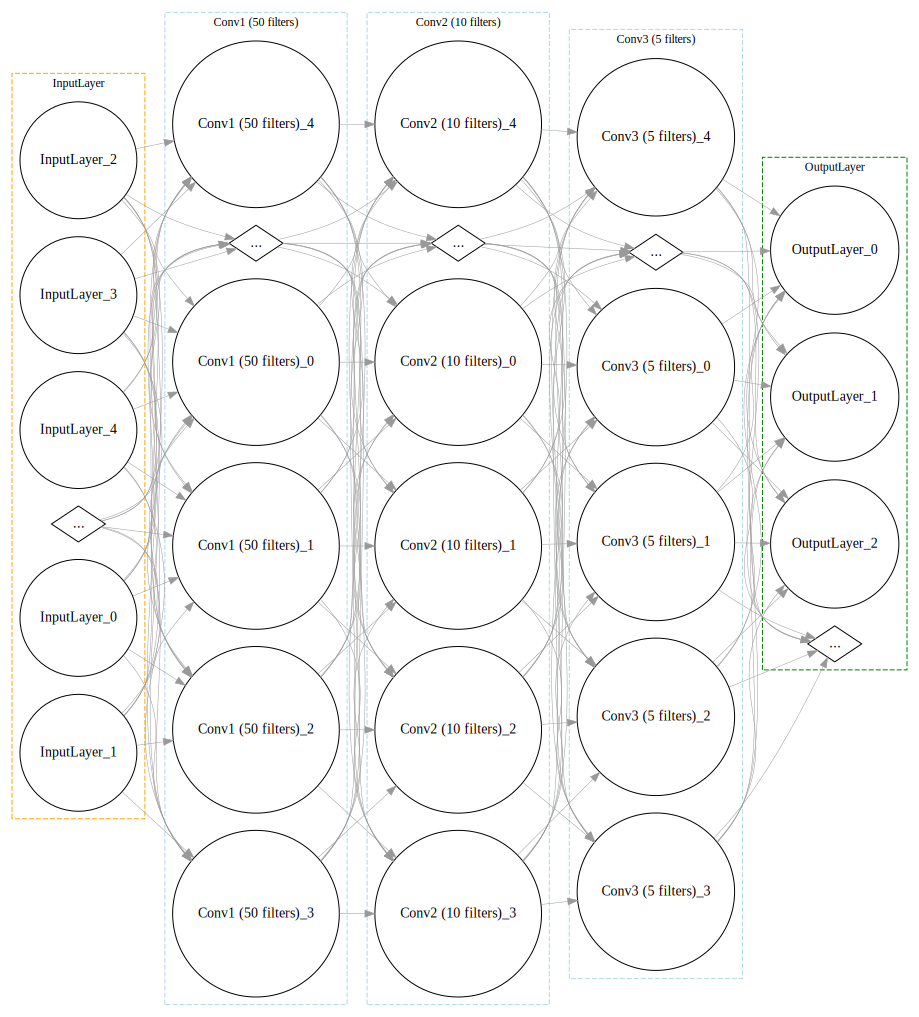

In [43]:
# -----------------------------------------
# 1) Install & import Graphviz
# -----------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

dot = Digraph('PartialCNN', format='png')
dot.attr(rankdir='LR')  # horizontal flow

# Helper function to create a "layer" of circles
def create_layer(dot, layer_name, num_nodes=5, shape='circle', color='lightgray'):
    """
    Creates a subgraph for a layer, drawing 'num_nodes' circles plus one '...' node
    to indicate the layer has many more neurons.
    Returns a list of node names for this layer.
    """
    with dot.subgraph(name=f"cluster_{layer_name}") as s:
        s.attr(label=layer_name, color=color, style='dashed', fontsize='12')

        node_names = []
        for i in range(num_nodes):
            node_id = f"{layer_name}_{i}"
            # Example label: "C1_0", "C1_1", etc.
            # but we can keep it simpler:
            s.node(node_id, shape=shape)
            node_names.append(node_id)

        # Add a "..." node to indicate more
        ellipsis_id = f"{layer_name}_ellipsis"
        s.node(ellipsis_id, label='...', shape='diamond')

        node_names.append(ellipsis_id)

    return node_names

def connect_layers(dot, layer1_nodes, layer2_nodes):
    """
    Fully connect each node in layer1 to each node in layer2.
    (In CNNs, it's not typically a 'fully-connected' link between feature maps,
    but we do this for a classic 'circle and line' neural network illustration.)
    """
    for n1 in layer1_nodes:
        for n2 in layer2_nodes:
            dot.edge(n1, n2, color="#999999", penwidth="0.5")

# -----------------------------------------
# 2) Build your partial CNN layers
# -----------------------------------------

# a) Input layer (represent 64x64x3 as ~ a handful of circles)
input_nodes = create_layer(dot, "InputLayer", num_nodes=5, color='orange')

# b) 1st Conv Layer => 50 filters (but we just represent them as 5 circles + ...)
conv1_nodes = create_layer(dot, "Conv1 (50 filters)", num_nodes=5, color='lightblue')

# c) 2nd Conv Layer => 10 filters
conv2_nodes = create_layer(dot, "Conv2 (10 filters)", num_nodes=5, color='lightblue')

# d) 3rd Conv Layer => 5 filters
conv3_nodes = create_layer(dot, "Conv3 (5 filters)", num_nodes=5, color='lightblue')

# e) Output layer (for example, let's just call it "Encoded" or "Output")
output_nodes = create_layer(dot, "OutputLayer", num_nodes=3, color='green')

# -----------------------------------------
# 3) Connect the layers
# -----------------------------------------
connect_layers(dot, input_nodes, conv1_nodes)
connect_layers(dot, conv1_nodes, conv2_nodes)
connect_layers(dot, conv2_nodes, conv3_nodes)
connect_layers(dot, conv3_nodes, output_nodes)

# -----------------------------------------
# 4) Render & Display
# -----------------------------------------
dot.render('PartialCNNDiagram', view=False)
dot


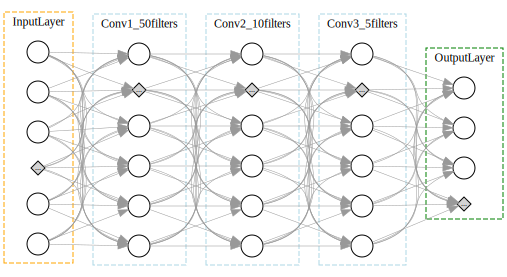

In [44]:
# -----------------------------------------
# 1) Install & import Graphviz
# -----------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

dot = Digraph('PartialCNN_SmallerNeurons', format='png')
dot.attr(rankdir='LR')  # horizontal flow

# Helper function to create a "layer" of circles
def create_layer(dot, layer_name, num_nodes=5, shape='circle', color='lightgray'):
    """
    Creates a subgraph for a layer, drawing 'num_nodes' small circles plus one '...' node
    to indicate the layer has many more neurons.
    Returns a list of node names for this layer.
    """
    with dot.subgraph(name=f"cluster_{layer_name}") as s:
        s.attr(label=layer_name, color=color, style='dashed', fontsize='12')

        node_names = []
        for i in range(num_nodes):
            node_id = f"{layer_name}_{i}"
            # Make each neuron a small circle:
            s.node(
                node_id,
                label="",              # no text inside the circle
                shape="circle",
                width="0.3",          # smaller width
                height="0.3",         # smaller height
                fixedsize="true",
                style="filled",
                fillcolor="white",
                fontsize="6"
            )
            node_names.append(node_id)

        # Add a "..." node to indicate more neurons exist
        ellipsis_id = f"{layer_name}_ellipsis"
        s.node(
            ellipsis_id,
            label="...",
            shape="diamond",
            width="0.2",
            height="0.2",
            fixedsize="true",
            style="filled",
            fillcolor="lightgrey",
            fontsize="8"
        )
        node_names.append(ellipsis_id)

    return node_names

def connect_layers(dot, layer1_nodes, layer2_nodes):
    """
    Fully connect each node in layer1 to each node in layer2
    for a classic 'circle and line' neural network look.
    """
    for n1 in layer1_nodes:
        for n2 in layer2_nodes:
            dot.edge(n1, n2, color="#999999", penwidth="0.5")

# -----------------------------------------
# 2) Build your partial CNN layers
# -----------------------------------------

# a) Input layer (represent 64x64x3 as ~a handful of circles)
input_nodes = create_layer(dot, "InputLayer", num_nodes=5, color='orange')

# b) 1st Conv Layer => 50 filters (just 5 circles + '...')
conv1_nodes = create_layer(dot, "Conv1_50filters", num_nodes=5, color='lightblue')

# c) 2nd Conv Layer => 10 filters
conv2_nodes = create_layer(dot, "Conv2_10filters", num_nodes=5, color='lightblue')

# d) 3rd Conv Layer => 5 filters
conv3_nodes = create_layer(dot, "Conv3_5filters", num_nodes=5, color='lightblue')

# e) Output layer
output_nodes = create_layer(dot, "OutputLayer", num_nodes=3, color='green')

# -----------------------------------------
# 3) Connect the layers
# -----------------------------------------
connect_layers(dot, input_nodes, conv1_nodes)
connect_layers(dot, conv1_nodes, conv2_nodes)
connect_layers(dot, conv2_nodes, conv3_nodes)
connect_layers(dot, conv3_nodes, output_nodes)

# -----------------------------------------
# 4) Render & Display
# -----------------------------------------
dot.render('PartialCNNDiagram_SmallerNeurons', view=False)
dot


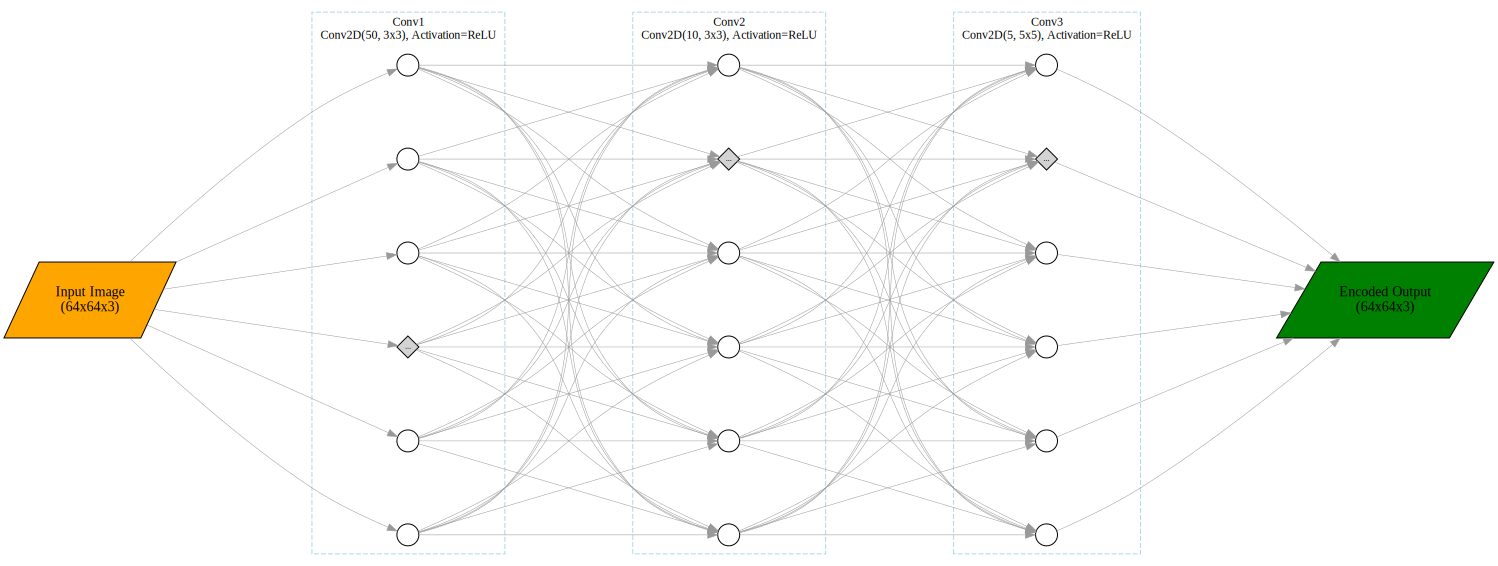

In [45]:
# -----------------------------------------
# 1) Install & import Graphviz
# -----------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

# Create the main Digraph
dot = Digraph('PartialCNN_SmallerNeurons_Activations', format='png')

# Increase horizontal spacing between layers:
# - ranksep controls separation between ranks (layers)
# - nodesep controls spacing between adjacent nodes
dot.attr(rankdir='LR', ranksep='2', nodesep='1')

def create_layer(dot, layer_name, num_nodes=5, color='lightgray',
                 filters=0, kernel='3x3', activation='ReLU'):
    """
    Creates a subgraph representing a layer:
      - 'num_nodes' small circles
      - one '...' node to indicate more neurons
    The subgraph label also includes the specified activation.
    Returns a list of node names (strings).
    """
    with dot.subgraph(name=f"cluster_{layer_name}") as s:
        # Subgraph label includes details like Conv2D filters, kernel size, activation
        s.attr(
            label=f"{layer_name}\nConv2D({filters}, {kernel}), Activation={activation}",
            color=color,
            style='dashed',
            fontsize='12'
        )

        node_names = []
        for i in range(num_nodes):
            node_id = f"{layer_name}_{i}"
            # Each neuron is a small circle:
            s.node(
                node_id,
                label="",       # no text inside the circle
                shape="circle",
                width="0.3",
                height="0.3",
                fixedsize="true",
                style="filled",
                fillcolor="white",
                fontsize="6"
            )
            node_names.append(node_id)

        # Add the "..." node to indicate many more neurons
        ellipsis_id = f"{layer_name}_ellipsis"
        s.node(
            ellipsis_id,
            label="...",
            shape="diamond",
            width="0.3",
            height="0.3",
            fixedsize="true",
            style="filled",
            fillcolor="lightgrey",
            fontsize="8"
        )
        node_names.append(ellipsis_id)

        return node_names

def connect_layers(dot, layer1_nodes, layer2_nodes):
    """
    Fully connect each node in layer1 to each node in layer2.
    This is a 'conceptual' representation for a CNN.
    """
    for n1 in layer1_nodes:
        for n2 in layer2_nodes:
            dot.edge(n1, n2, color="#999999", penwidth="0.5")

# -----------------------------------------
# 2) Build your partial CNN layers
# -----------------------------------------

# Input layer (pretend 64x64x3) - just 5 circles plus "..."
dot.node("InputLabel", label="Input Image\n(64x64x3)", shape="parallelogram", style="filled", fillcolor="orange")

# 1st Conv layer: 50 filters, 3x3, ReLU
conv1_nodes = create_layer(
    dot,
    layer_name="Conv1",
    num_nodes=5,
    color='lightblue',
    filters=50,
    kernel="3x3",
    activation="ReLU"
)

# 2nd Conv layer: 10 filters, 3x3, ReLU
conv2_nodes = create_layer(
    dot,
    layer_name="Conv2",
    num_nodes=5,
    color='lightblue',
    filters=10,
    kernel="3x3",
    activation="ReLU"
)

# 3rd Conv layer: 5 filters, 5x5, ReLU
conv3_nodes = create_layer(
    dot,
    layer_name="Conv3",
    num_nodes=5,
    color='lightblue',
    filters=5,
    kernel="5x5",
    activation="ReLU"
)

# Output layer: e.g. "Encoded Output" with 3 channels
dot.node("OutputLabel", label="Encoded Output\n(64x64x3)", shape="parallelogram", style="filled", fillcolor="green")

# -----------------------------------------
# 3) Connect the layers
# -----------------------------------------
# Connect input to the first conv layer:
# We'll connect from "InputLabel" to each circle in conv1
for c1_node in conv1_nodes:
    dot.edge("InputLabel", c1_node, color="#999999", penwidth="0.5")

# Connect conv1 -> conv2
connect_layers(dot, conv1_nodes, conv2_nodes)
# Connect conv2 -> conv3
connect_layers(dot, conv2_nodes, conv3_nodes)
# Connect conv3 -> Output
for c3_node in conv3_nodes:
    dot.edge(c3_node, "OutputLabel", color="#999999", penwidth="0.5")

# -----------------------------------------
# 4) Render & Display
# -----------------------------------------
dot.render('PartialCNNDiagram_SmallerNeurons_Activations', view=False)
dot


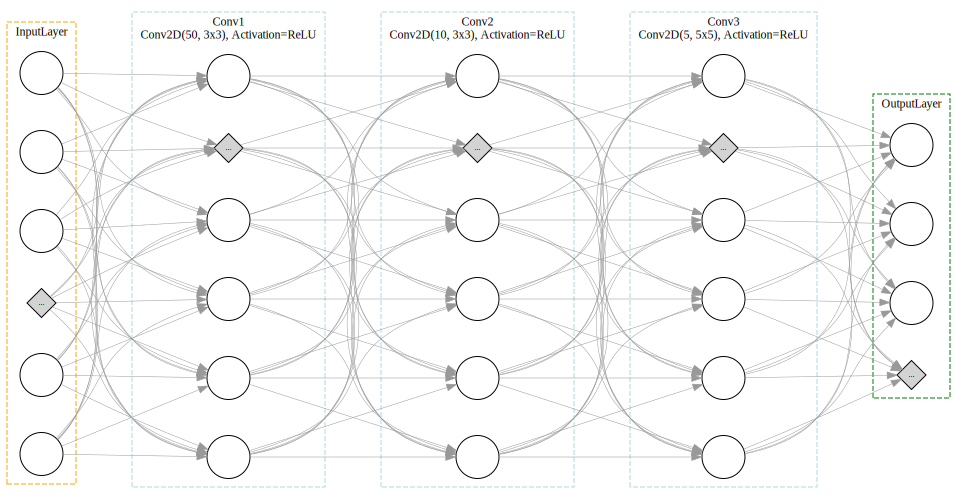

In [52]:
# -----------------------------------------
# 1) Install & import Graphviz
# -----------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

# Create the main Digraph
dot = Digraph('LabeledCircleCNN_NoNumbering', format='png')

# Decrease horizontal spacing:
dot.attr(rankdir='LR', ranksep='1', nodesep='0.5')

def create_layer(
    dot,
    layer_index,
    layer_name,
    num_nodes=5,
    color='lightgray',
    filters=0,
    kernel='3x3',
    activation='ReLU'
):
    """
    Creates a subgraph representing one layer of the CNN:
      - 'num_nodes' circle nodes (unlabeled).
      - One '...' node to indicate more neurons.
      - Subgraph label includes Conv details & activation if relevant.
    Returns a list of node names (strings) for the newly created nodes.
    """
    with dot.subgraph(name=f"cluster_{layer_name}") as s:
        # Construct subgraph label
        if filters > 0:
            label_text = (f"{layer_name}\nConv2D({filters}, {kernel}), "
                          f"Activation={activation}")
        else:
            label_text = layer_name

        s.attr(
            label=label_text,
            color=color,
            style='dashed',
            fontsize='12'
        )

        node_names = []
        for i in range(num_nodes):
            # Create a unique node ID, but no visible label
            neuron_id = f"{layer_name}_node{i}"
            s.node(
                neuron_id,
                label="",
                shape="circle",
                width="0.6",
                height="0.6",
                fixedsize="true",
                style="filled",
                fillcolor="white",
                fontsize="10"
            )
            node_names.append(neuron_id)

        # Add the "..." node to indicate more neurons
        ellipsis_id = f"{layer_name}_ellipsis"
        s.node(
            ellipsis_id,
            label="...",
            shape="diamond",
            width="0.4",
            height="0.4",
            fixedsize="true",
            style="filled",
            fillcolor="lightgrey",
            fontsize="8"
        )
        node_names.append(ellipsis_id)

        return node_names

def connect_layers(dot, layer1_nodes, layer2_nodes):
    """
    Fully connect each node in layer1 to each node in layer2.
    """
    for n1 in layer1_nodes:
        for n2 in layer2_nodes:
            dot.edge(n1, n2, color="#999999", penwidth="0.5")

# -----------------------------------------
# 2) Build your partial CNN layers
# -----------------------------------------

# (a) Input Layer (layer_index=1)
input_nodes = create_layer(
    dot,
    layer_index=1,
    layer_name="InputLayer",
    num_nodes=5,
    color='orange',
    filters=0,
    kernel="N/A",
    activation="N/A"
)

# (b) Conv Layer 1 (layer_index=2): 50 filters, 3x3, ReLU
conv1_nodes = create_layer(
    dot,
    layer_index=2,
    layer_name="Conv1",
    num_nodes=5,
    color='lightblue',
    filters=50,
    kernel="3x3",
    activation="ReLU"
)

# (c) Conv Layer 2 (layer_index=3): 10 filters, 3x3, ReLU
conv2_nodes = create_layer(
    dot,
    layer_index=3,
    layer_name="Conv2",
    num_nodes=5,
    color='lightblue',
    filters=10,
    kernel="3x3",
    activation="ReLU"
)

# (d) Conv Layer 3 (layer_index=4): 5 filters, 5x5, ReLU
conv3_nodes = create_layer(
    dot,
    layer_index=4,
    layer_name="Conv3",
    num_nodes=5,
    color='lightblue',
    filters=5,
    kernel="5x5",
    activation="ReLU"
)

# (e) Output Layer (layer_index=5)
output_nodes = create_layer(
    dot,
    layer_index=5,
    layer_name="OutputLayer",
    num_nodes=3,
    color='green',
    filters=0,
    kernel="N/A",
    activation="N/A"
)

# -----------------------------------------
# 3) Connect the layers
# -----------------------------------------
connect_layers(dot, input_nodes, conv1_nodes)
connect_layers(dot, conv1_nodes, conv2_nodes)
connect_layers(dot, conv2_nodes, conv3_nodes)
connect_layers(dot, conv3_nodes, output_nodes)

# -----------------------------------------
# 4) Render & Display
# -----------------------------------------
dot.render('LabeledCircleCNNDiagram_ReducedSpacing', view=False)
dot


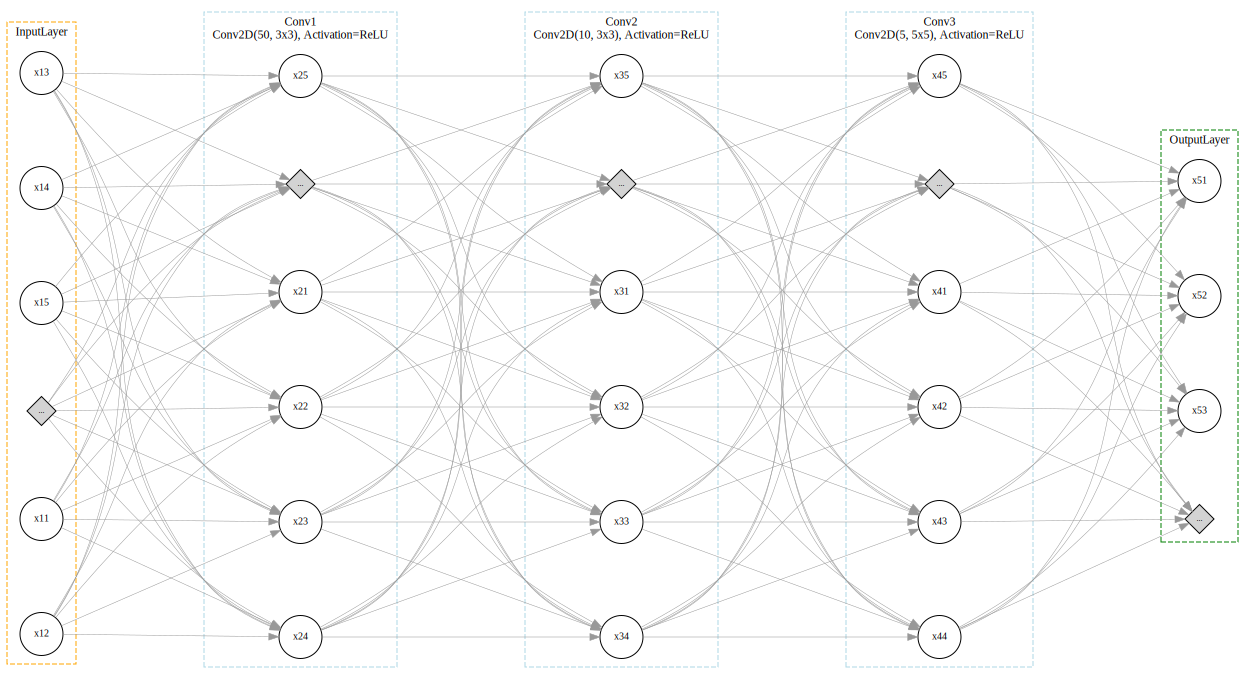

In [46]:
# -----------------------------------------
# 1) Install & import Graphviz
# -----------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

# Create the main Digraph
dot = Digraph('LabeledCircleCNN', format='png')

# Increase horizontal spacing so nodes aren’t too cramped
dot.attr(rankdir='LR', ranksep='2', nodesep='1')

def create_layer(
    dot,
    layer_index,      # numeric index (1, 2, 3, ...)
    layer_name,       # e.g. "InputLayer", "Conv1", "OutputLayer", etc.
    num_nodes=5,
    color='lightgray',
    filters=0,
    kernel='3x3',
    activation='ReLU'
):
    """
    Creates a subgraph representing one layer of the CNN:
    - 'num_nodes' circle nodes, each labeled "xL<N>"
        where L=layer_index, N is neuron index (1..num_nodes)
    - one '...' node to indicate more neurons
    The subgraph label includes Conv details & activation if relevant.

    Returns a list of node names (strings) for the newly created nodes
    (so we can connect them to the next layer).
    """
    with dot.subgraph(name=f"cluster_{layer_name}") as s:
        # Subgraph label: show layer name, filters, kernel, activation
        # (Adjust the text if you prefer simpler or more detail.)
        if filters > 0:
            label_text = (f"{layer_name}\nConv2D({filters}, {kernel}), "
                          f"Activation={activation}")
        else:
            label_text = layer_name  # e.g. for "InputLayer"

        s.attr(
            label=label_text,
            color=color,
            style='dashed',
            fontsize='12'
        )

        node_names = []
        # Create each neuron in this layer
        for i in range(num_nodes):
            neuron_label = f"x{layer_index}{i+1}"  # e.g. x11, x12, ...
            neuron_id = f"{layer_name}_{neuron_label}"

            s.node(
                neuron_id,
                label=neuron_label,          # show the label inside the circle
                shape="circle",
                width="0.6",                # bigger circle radius
                height="0.6",
                fixedsize="true",
                style="filled",
                fillcolor="white",
                fontsize="10"
            )
            node_names.append(neuron_id)

        # Add the "..." node to indicate more neurons exist
        ellipsis_id = f"{layer_name}_ellipsis"
        s.node(
            ellipsis_id,
            label="...",
            shape="diamond",
            width="0.4",
            height="0.4",
            fixedsize="true",
            style="filled",
            fillcolor="lightgrey",
            fontsize="8"
        )
        node_names.append(ellipsis_id)

        return node_names

def connect_layers(dot, layer1_nodes, layer2_nodes):
    """
    Fully connect each node in layer1 to each node in layer2
    for a classic 'circle and line' neural network look.
    """
    for n1 in layer1_nodes:
        for n2 in layer2_nodes:
            dot.edge(n1, n2, color="#999999", penwidth="0.5")

# -----------------------------------------
# 2) Build your partial CNN layers
# -----------------------------------------

# (a) Input Layer (layer_index=1)
# e.g., 64x64x3 is huge, but we'll show just 5 labeled neurons
input_nodes = create_layer(
    dot,
    layer_index=1,
    layer_name="InputLayer",
    num_nodes=5,
    color='orange',      # bounding box color
    filters=0,           # no filters, not a conv layer
    kernel="N/A",
    activation="N/A"
)

# (b) Conv Layer 1 (layer_index=2): 50 filters, 3x3, ReLU
conv1_nodes = create_layer(
    dot,
    layer_index=2,
    layer_name="Conv1",
    num_nodes=5,
    color='lightblue',
    filters=50,
    kernel="3x3",
    activation="ReLU"
)

# (c) Conv Layer 2 (layer_index=3): 10 filters, 3x3, ReLU
conv2_nodes = create_layer(
    dot,
    layer_index=3,
    layer_name="Conv2",
    num_nodes=5,
    color='lightblue',
    filters=10,
    kernel="3x3",
    activation="ReLU"
)

# (d) Conv Layer 3 (layer_index=4): 5 filters, 5x5, ReLU
conv3_nodes = create_layer(
    dot,
    layer_index=4,
    layer_name="Conv3",
    num_nodes=5,
    color='lightblue',
    filters=5,
    kernel="5x5",
    activation="ReLU"
)

# (e) Output Layer (layer_index=5)
output_nodes = create_layer(
    dot,
    layer_index=5,
    layer_name="OutputLayer",
    num_nodes=3,
    color='green',
    filters=0,
    kernel="N/A",
    activation="N/A"
)

# -----------------------------------------
# 3) Connect the layers
# -----------------------------------------
connect_layers(dot, input_nodes, conv1_nodes)
connect_layers(dot, conv1_nodes, conv2_nodes)
connect_layers(dot, conv2_nodes, conv3_nodes)
connect_layers(dot, conv3_nodes, output_nodes)

# -----------------------------------------
# 4) Render & Display
# -----------------------------------------
dot.render('LabeledCircleCNNDiagram', view=False)
dot


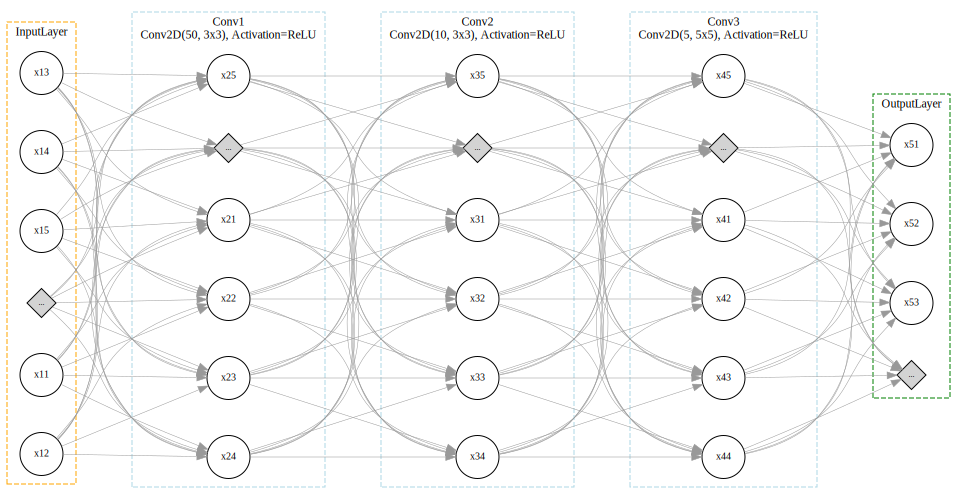

In [47]:
# -----------------------------------------
# 1) Install & import Graphviz
# -----------------------------------------
!apt-get -qq install graphviz
!pip install graphviz

from graphviz import Digraph

# Create the main Digraph
dot = Digraph('LabeledCircleCNN', format='png')

# Decrease horizontal spacing:
# - ranksep controls spacing between ranks (layers)
# - nodesep controls spacing between adjacent nodes
dot.attr(rankdir='LR', ranksep='1', nodesep='0.5')

def create_layer(
    dot,
    layer_index,
    layer_name,
    num_nodes=5,
    color='lightgray',
    filters=0,
    kernel='3x3',
    activation='ReLU'
):
    """
    Creates a subgraph representing one layer of the CNN:
      - 'num_nodes' circle nodes, each labeled "xL<N>"
      - one '...' node to indicate more neurons
    The subgraph label includes Conv details & activation if relevant.
    Returns a list of node names (strings) for the newly created nodes.
    """
    with dot.subgraph(name=f"cluster_{layer_name}") as s:
        # Construct subgraph label
        if filters > 0:
            label_text = (f"{layer_name}\nConv2D({filters}, {kernel}), "
                          f"Activation={activation}")
        else:
            label_text = layer_name

        s.attr(
            label=label_text,
            color=color,
            style='dashed',
            fontsize='12'
        )

        node_names = []
        for i in range(num_nodes):
            neuron_label = f"x{layer_index}{i+1}"  # e.g. x11, x12, ...
            neuron_id = f"{layer_name}_{neuron_label}"

            s.node(
                neuron_id,
                label=neuron_label,
                shape="circle",
                width="0.6",
                height="0.6",
                fixedsize="true",
                style="filled",
                fillcolor="white",
                fontsize="10"
            )
            node_names.append(neuron_id)

        # Add the "..." node to indicate more neurons
        ellipsis_id = f"{layer_name}_ellipsis"
        s.node(
            ellipsis_id,
            label="...",
            shape="diamond",
            width="0.4",
            height="0.4",
            fixedsize="true",
            style="filled",
            fillcolor="lightgrey",
            fontsize="8"
        )
        node_names.append(ellipsis_id)

        return node_names

def connect_layers(dot, layer1_nodes, layer2_nodes):
    """
    Fully connect each node in layer1 to each node in layer2.
    """
    for n1 in layer1_nodes:
        for n2 in layer2_nodes:
            dot.edge(n1, n2, color="#999999", penwidth="0.5")

# -----------------------------------------
# 2) Build your partial CNN layers
# -----------------------------------------

# (a) Input Layer (layer_index=1)
input_nodes = create_layer(
    dot,
    layer_index=1,
    layer_name="InputLayer",
    num_nodes=5,
    color='orange',
    filters=0,
    kernel="N/A",
    activation="N/A"
)

# (b) Conv Layer 1 (layer_index=2): 50 filters, 3x3, ReLU
conv1_nodes = create_layer(
    dot,
    layer_index=2,
    layer_name="Conv1",
    num_nodes=5,
    color='lightblue',
    filters=50,
    kernel="3x3",
    activation="ReLU"
)

# (c) Conv Layer 2 (layer_index=3): 10 filters, 3x3, ReLU
conv2_nodes = create_layer(
    dot,
    layer_index=3,
    layer_name="Conv2",
    num_nodes=5,
    color='lightblue',
    filters=10,
    kernel="3x3",
    activation="ReLU"
)

# (d) Conv Layer 3 (layer_index=4): 5 filters, 5x5, ReLU
conv3_nodes = create_layer(
    dot,
    layer_index=4,
    layer_name="Conv3",
    num_nodes=5,
    color='lightblue',
    filters=5,
    kernel="5x5",
    activation="ReLU"
)

# (e) Output Layer (layer_index=5)
output_nodes = create_layer(
    dot,
    layer_index=5,
    layer_name="OutputLayer",
    num_nodes=3,
    color='green',
    filters=0,
    kernel="N/A",
    activation="N/A"
)

# -----------------------------------------
# 3) Connect the layers
# -----------------------------------------
connect_layers(dot, input_nodes, conv1_nodes)
connect_layers(dot, conv1_nodes, conv2_nodes)
connect_layers(dot, conv2_nodes, conv3_nodes)
connect_layers(dot, conv3_nodes, output_nodes)

# -----------------------------------------
# 4) Render & Display
# -----------------------------------------
dot.render('LabeledCircleCNNDiagram_ReducedSpacing', view=False)
dot
